In [1]:
using JLD2, CairoMakie
using StatsBase, FreqTables
using Jchemo, JchemoData

In [2]:
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data/forages2.jld2")
@load db dat
pnames(dat)

(:X, :Y)

In [3]:
X = dat.X
Y = dat.Y
ntot = nro(X)

485

In [4]:
@head X

... (485, 700)
 


Row,1100,1102,1104,1106,1108,1110,1112,1114,1116,1118,1120,1122,1124,1126,1128,1130,1132,1134,1136,1138,1140,1142,1144,1146,1148,1150,1152,1154,1156,1158,1160,1162,1164,1166,1168,1170,1172,1174,1176,1178,1180,1182,1184,1186,1188,1190,1192,1194,1196,1198,1200,1202,1204,1206,1208,1210,1212,1214,1216,1218,1220,1222,1224,1226,1228,1230,1232,1234,1236,1238,1240,1242,1244,1246,1248,1250,1252,1254,1256,1258,1260,1262,1264,1266,1268,1270,1272,1274,1276,1278,1280,1282,1284,1286,1288,1290,1292,1294,1296,1298,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,-0.000231591,-0.000175945,-8.48176e-5,2.05217e-5,0.000110094,0.000161757,0.000154953,0.000163754,0.000187602,0.00021499,0.000242479,0.000265498,0.000282141,0.000281442,0.000271025,0.000261075,0.000257284,0.000252177,0.00024293,0.000228295,0.000219097,0.000214136,0.000215612,0.000218982,0.000228004,0.000236081,0.000236017,0.000220327,0.000187096,0.000137138,7.68593e-5,1.13679e-5,-5.00951e-5,-9.54664e-5,-0.000119199,-0.000131897,-0.000142349,-0.000161489,-0.00019387,-0.000244808,-0.000303259,-0.000366904,-0.000416738,-0.000451535,-0.00046995,-0.000478637,-0.000477348,-0.000478142,-0.000476719,-0.000479701,-0.000482037,-0.000496769,-0.000511959,-0.000532094,-0.000542661,-0.000540188,-0.000512715,-0.00045798,-0.000370395,-0.000256256,-0.000126907,1.13716e-6,0.000119047,0.000212745,0.000275685,0.000307863,0.000313547,0.000296977,0.000269661,0.000247818,0.000233944,0.000228773,0.000224567,0.000221256,0.000218893,0.000217741,0.000210144,0.00019664,0.000181949,0.000169774,0.000151691,0.00012385,9.23378e-5,5.9959e-5,2.58352e-5,-4.77314e-6,-3.21835e-5,-5.53154e-5,-6.71707e-5,-6.54166e-5,-5.16448e-5,-2.43366e-5,1.12255e-5,4.68917e-5,7.773e-5,0.000106785,0.000133173,0.000153607,0.000168518,0.000182591,⋯
2,-9.66352e-5,-3.30928e-5,5.64966e-5,0.000154135,0.000237725,0.000295789,0.000319587,0.000357405,0.000404611,0.000447996,0.000479786,0.000488339,0.000465929,0.000402301,0.000313648,0.000220226,0.000138483,7.35084e-5,3.50018e-5,2.83293e-5,6.05478e-5,0.000118272,0.000187726,0.000249842,0.00029697,0.000315062,0.000298828,0.000251643,0.000187055,0.000118243,5.60849e-5,3.8727e-6,-3.28778e-5,-4.84688e-5,-4.38912e-5,-3.34954e-5,-2.72637e-5,-3.65483e-5,-6.62949e-5,-0.000121833,-0.000193587,-0.000280244,-0.000362132,-0.000434981,-0.000494461,-0.000546531,-0.000590606,-0.000638514,-0.000684688,-0.000734688,-0.000783664,-0.000842714,-0.000892596,-0.000930301,-0.000938118,-0.000913585,-0.000846217,-0.000737781,-0.000588122,-0.000410395,-0.000220611,-3.69382e-5,0.000131072,0.000266078,0.000358377,0.000408684,0.000424528,0.000412147,0.000383896,0.000357957,0.000338385,0.000326749,0.000315572,0.00030542,0.000293671,0.000280005,0.000259482,0.000233697,0.0002044,0.000177199,0.000147989,0.000112325,7.33317e-5,3.48779e-5,-2.5229e-6,-3.27922e-5,-5.52233e-5,-7.06412e-5,-7.49675e-5,-6.44041e-5,-4.04393e-5,-6.50489e-6,3.09196e-5,6.87358e-5,0.000105202,0.000142313,0.000177182,0.000206652,0.000230788,0.000253703,⋯
3,-0.000131769,-7.8398e-5,7.92223e-7,8.90044e-5,0.000160022,0.000198435,0.000196598,0.000212225,0.000241109,0.000271235,0.000301045,0.000324921,0.000337619,0.000325857,0.00029979,0.000277167,0.00027018,0.00027165,0.000277606,0.000287722,0.000308203,0.000324847,0.000328

In [5]:
@head Y

... (485, 4)
 


Row,dm,ndf,typ,test
,Float64?,Float64?,String,Int64
1,92.23,37.58,Legume forages,1
2,93.26,49.6462,Legume forages,0
3,92.9,63.2939,Forage trees,0


In [6]:
y = Y.typ
tab(y)

OrderedCollections.OrderedDict{String, Int64} with 3 entries:
  "Cereal and grass forages" => 160
  "Forage trees"             => 101
  "Legume forages"           => 224

In [7]:
freqtable(y, Y.test)

3×2 Named Matrix{Int64}
             Dim1 ╲ Dim2 │   0    1
─────────────────────────┼─────────
Cereal and grass forages │ 100   60
Forage trees             │  56   45
Legume forages           │ 167   57

In [8]:
wl = names(X)
wl_num = parse.(Float64, wl)

700-element Vector{Float64}:
 1100.0
 1102.0
 1104.0
 1106.0
 1108.0
 1110.0
 1112.0
 1114.0
 1116.0
 1118.0
    ⋮
 2482.0
 2484.0
 2486.0
 2488.0
 2490.0
 2492.0
 2494.0
 2496.0
 2498.0

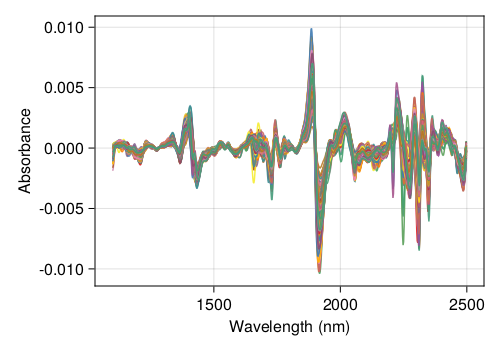

In [9]:
# X is already preprocessed
plotsp(X, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

In [10]:
s = Bool.(Y.test)
Xtrain = rmrow(X, s)
ytrain = rmrow(y, s)
Xtest = X[s, :]
ytest = y[s]
ntrain = nro(Xtrain)
ntest = nro(Xtest)
(ntot = ntot, ntrain, ntest)

(ntot = 485, ntrain = 323, ntest = 162)

In [11]:
# Train ==> Cal + Val
pct = .30
nval = Int64.(round(pct * ntrain))
ncal = ntrain - nval
s = sample(1:ntrain, nval; replace = false)
Xcal = rmrow(Xtrain, s)
ycal = rmrow(ytrain, s)
Xval = Xtrain[s, :]
yval = ytrain[s]
(ntot = ntot, ntrain, ncal, nval, ntest)

(ntot = 485, ntrain = 323, ncal = 226, nval = 97, ntest = 162)

In [12]:
nlv = 0:50
gamma = 10.0.^(-5:3)
pars = mpar(gamma = gamma)

(gamma = [1.0e-5, 0.0001, 0.001, 0.010000000000000002, 0.1, 1.0, 10.0, 100.0, 1000.0],)

In [13]:
length(pars[1])

9

In [14]:
res = gridscorelv(Xcal, ycal, Xval, yval;
    score = err, fun = kplsrda, pars = pars, nlv = nlv)

Row,gamma,nlv,y1
,Float64,Int64,Float64
1,1.0e-5,0,0.412371
2,1.0e-5,1,0.268041
3,1.0e-5,2,0.226804
4,1.0e-5,3,0.185567
5,1.0e-5,4,0.195876
6,1.0e-5,5,0.0927835
7,1.0e-5,6,0.123711
8,1.0e-5,7,0.123711
9,1.0e-5,8,0.123711


In [15]:
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,gamma,nlv,y1
,Float64,Int64,Float64
237,0.1,32,0.0618557


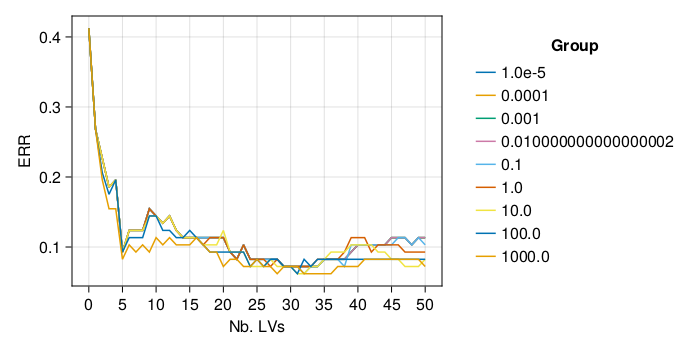

In [16]:
plotgrid(res.nlv, res.y1, res.gamma; step = 5,
    xlabel = "Nb. LVs", ylabel = "ERR").f

In [17]:
fm = kplsrda(Xtrain, ytrain; nlv = res.nlv[u],
    gamma = res.gamma[u]) ;
pred = Jchemo.predict(fm, Xtest).pred
err(pred, ytest)

1×1 Matrix{Float64}:
 0.06172839506172839

In [18]:
cf = confusion(pred, ytest) ;
cf.cnt

Row,y,pred_Cereal and grass forages,pred_Forage trees,pred_Legume forages
,String,Int64,Int64,Int64
1,Cereal and grass forages,57,0,3
2,Forage trees,0,38,7
3,Legume forages,0,0,57


In [19]:
cf.pct

Row,levels,pred_Cereal and grass forages,pred_Forage trees,pred_Legume forages
,String,Float64,Float64,Float64
1,Cereal and grass forages,95.0,0.0,5.0
2,Forage trees,0.0,84.4,15.6
3,Legume forages,0.0,0.0,100.0


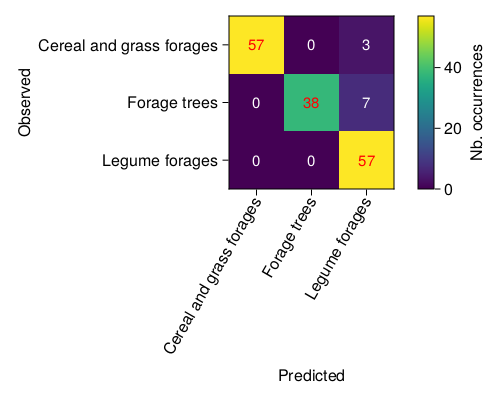

In [20]:
plotconf(cf).f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*